# Clasificación de frases

En este apartado planteamos el uso de las arquitecturas vistas hasta ahora para crear un clasificador de noticias en inglés.
En concreto utilizaremos este dataset:
https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/code
Que clasifica las noticias en 4 tipos, "world", "sports", "business", y "Science"

Lo que haremos primero será obtener el conjunto de datos de entrenamiento, cargarlo en un dataframe de pandas, seleccionar las columnas "Title" y "Class Index" y almacenar los datos con el formato que utilizaremos para entrenar, 2 listas, la "data" y la "data_labels".

En concreto las listas:

1. **data**, contendrá todos los títulos de las noticias
2. **data_labels**, todas las etiquetas.


Ambas listas deben tener el mismo tamaño*, ya que por un lado están las noticias, y cada noticia tiene una etiqueta.

Se puede samplear el corpus y tomar sólo las 10000 primeras entradas para que el script vaya más rápido. Más adelante podremos realizar pruebas para ver si añadiendo más entradas tenemos mejores resultados.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


train=pd.read_csv('class/train.csv')

train_sample=train.sample(n=10000)
title=train_sample['Title'].tolist()
tag=train_sample['Class Index'].tolist()

print (len(title))
print (len(tag))

data=[]
data_labels=[]
for i in range (0, len(title)):
    data.append(title[i])
    data_labels.append(tag[i])

10000
10000


Al final de este apartado necesitaremos probar un modelo con más datos, así que encapsulamos el código anterior en una función a la que le pasaremos un valor *n* indicando el número de datos a tomar del archivo de train.csv.

In [6]:
def get_data_and_labels(path, n):
    train=pd.read_csv(path)

    train_sample=train.sample(n=n)
    title=train_sample['Title'].tolist()
    tag=train_sample['Class Index'].tolist()

    print (len(title))
    print (len(tag))

    data=[]
    data_labels=[]
    for i in range (0, len(title)):
        data.append(title[i])
        data_labels.append(tag[i])
        
    return train_sample, data, data_labels

Cogemos 10.000 elementos del dataset.

In [7]:
train_sample, data, data_labels = get_data_and_labels('class/train.csv', 10000)

10000
10000


**Visualice la distribución de textos por clase.**

Importamos las librerías necesarias.

In [7]:
import matplotlib.pyplot as plt

Empecemos viendo una muestra de los datos.

In [9]:
train_sample.head()

Class Index                                              Title  \
33607             1  CBS Says It Was Misled Over Bush Military Memo...   
109758            1    U.N., Cambodia to Thrash Out Khmer Rouge Trials   
83186             2                      Nets top Bulls in 2 overtimes   
108000            3                       Argentina can wait, says IMF   
11251             4           Merchant group helps DOJ in fraud stings   

                                              Description  
33607   Reuters - In a blow to its credibility, CBS Ne...  
109758   PHNOM PENH (Reuters) - The last details of ho...  
83186   Alonzo Mourning was his dominant old self in h...  
108000  The IMF has said it will negotiate with Argent...  
11251   A group representing online merchants said it ...

In [10]:
np.unique(data_labels)

array([1, 2, 3, 4])

Podemos comprobar que el dataset está formado por la clase a la que pertenece la noticia, el título y la descripción.

Lo que haremos a continuación es ver la distribución de clases que tenemos. Para ello podemos utilizar un gráfico de barras.

Para obtener las clases únicas de los textos y el total nos ayudaremos de la función unique() de numpy.

In [11]:
keys, counts = np.unique(data_labels, return_counts=True)

Visualizamos el gráfico de barras.

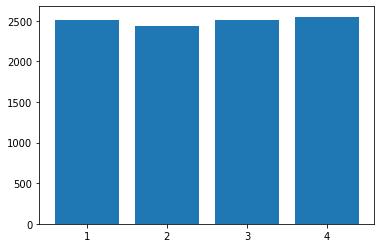

In [12]:
plt.bar(keys, counts)
plt.xticks(keys,keys)
plt.show()

Con esta visualización comprobamos fácilmente que las noticias que tenemos están distribuidas de forma uniforme entre las posibles clases a las que pueden pertenecer. Tenemos unos 2.500 títulos para cada clase, que según la información de Kaggle se corresponden a:
- 1 -> World
- 2 -> Sports
- 3 -> Business
- 4 -> Sci/Tech

Preparamos y preprocesamos los datos para el entrenamiento. Utilizaremos one-hot encoding por las etiquetas.

In [ ]:
#!pip install sklearn

In [14]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = array(data_labels)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)


[1 1 2 ... 4 4 4]
[0 0 1 ... 3 3 3]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Al igual que la función anterior, necesitaremos reutilizar este código, así que definimos una función.

In [15]:
def get_one_hot_encoding(data):
    values = array(data)
    print(values)

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)
    
    return onehot_encoded

Codificamos las etiquetas.

In [16]:
onehot_encoded = get_one_hot_encoding(data_labels)

[1 1 2 ... 4 4 4]
[0 0 1 ... 3 3 3]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## 2.1 Preparar datos y embeddings para entrenar
El modelo consistirá en:

- una capa embedding con los pesos del modelo Glove preentrenado para el inglés disponible en el archivo 'glove.42B.300d.txt'
- una capa LSTM con un número de unidos a elegir (por ejemplo, 300)
- una capa Dense con una dimensión de salida que tiene el número de categorías con las que queremos clasificar (en este caso, 4).
- Además, como función `loss` utilizaremos 'categorical_crossentropy' y como `optimizer`, 'adam'.

**Primeramente creamos un tokenizador para las frases del clasificador**

Importamos las librerías necesarias.

In [8]:
import nltk
from nltk import word_tokenize

Cargamos las stopwords del inglés.

In [18]:
stopwords = nltk.corpus.stopwords.words('english')

Antes de tokenizar los títulos de las noticias, las trataremos un poco para eliminar gran parte del ruido como hemos aprendido a lo largo de la asignatura. Lo que haremos será eliminar los signos de puntuación, pasar a minúsculas y eliminar stopwords.

Definimos una función que realice estos tres pasos.

In [19]:
def clean_text(text):
    # Eliminamos signos de puntuación
    text_clean = [s.translate(str.maketrans('', '', string.punctuation)) for s in text]

    # Pasamos el texto a minúscula
    for i in range(len(text_clean)):
        text_clean[i] = text_clean[i].lower()

    # Eliminar stopwords
    for i in range(len(text_clean)):
        tokens = word_tokenize(text_clean[i])
        tokens = [t for t in tokens if t not in stopwords]
        text_clean[i] = ' '.join(tokens)
    
    return text_clean

Aplicamos la función.

In [20]:
# Antes
print('Abans del preprocessat')
print('----------------------')
print(data[0:5])
print('\n')

data_clean = clean_text(data)

# Después
print('Després del preprocessat')
print('------------------------')
print(data_clean[0:5])

Abans del preprocessat
----------------------
['CBS Says It Was Misled Over Bush Military Memos (Reuters)', 'U.N., Cambodia to Thrash Out Khmer Rouge Trials', 'Nets top Bulls in 2 overtimes', 'Argentina can wait, says IMF', 'Merchant group helps DOJ in fraud stings']


Després del preprocessat
------------------------
['cbs says misled bush military memos reuters', 'un cambodia thrash khmer rouge trials', 'nets top bulls 2 overtimes', 'argentina wait says imf', 'merchant group helps doj fraud stings']


Ahora podemos continuar con el texto tratado.

Empezaremos tokenizando los títulos para crear el diccionario. Lo haremos mediante la función *tokenization()* del punto 1.

In [23]:
news_tokenizer = tokenization(data_clean)

Comprobamos.

In [24]:
print(news_tokenizer.word_index)

{'ap': 1, '39s': 2, 'us': 3, 'reuters': 4, 'new': 5, '39': 6, 'ltbgtltbgt': 7, 'oil': 8, 'says': 9, 'iraq': 10, 'microsoft': 11, 'afp': 12, 'deal': 13, 'stocks': 14, 'china': 15, 'world': 16, 'wins': 17, 'may': 18, 'bush': 19, 'win': 20, 'profit': 21, 'un': 22, 'game': 23, 'security': 24, 'report': 25, 'update': 26, 'sales': 27, 'ibm': 28, 'google': 29, 'talks': 30, 'back': 31, 'open': 32, 'set': 33, 'top': 34, 'first': 35, 'rise': 36, '2': 37, 'takes': 38, 'bid': 39, 'gets': 40, 'intel': 41, 'prices': 42, 'court': 43, 'big': 44, 'plan': 45, 'killed': 46, 'search': 47, 'two': 48, 'india': 49, 'buy': 50, 'japan': 51, 'record': 52, 'plans': 53, 'higher': 54, 'million': 55, 'group': 56, 'team': 57, 'eu': 58, '1': 59, 'hits': 60, 'bomb': 61, 'lead': 62, 'wireless': 63, 'shares': 64, 'red': 65, 'dollar': 66, 'get': 67, 'kills': 68, 'chief': 69, 'oracle': 70, 'sox': 71, 'gaza': 72, 'growth': 73, 'gold': 74, 'fall': 75, 'pc': 76, 'iran': 77, 'australia': 78, 'space': 79, 'price': 80, 'hit': 8

Parece que se ha ejecutado correctamente.

**Cargamos el siguiente modelo GloVe para el inglés.**

In [29]:
start = time.time()

import numpy as np

embeddings_index = {}
f = open('glove.42B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

end = time.time()
print(end - start)

dict

**Una vez cargado el modelo de GloVe definimos la capa de embedding con todos los pesos.**

Seguimos los pasos del punto anterior para obtener los embeddings correspondientes a nuestro diccionario. Hacemos uso de la misma función, pero sustituyendo el tokenizer que va a utilizar.

In [32]:
embedding_matrix = get_embedding_matrix(embeddings_index, news_tokenizer)

# Comprobamos
print(len(embedding_matrix))
embedding_matrix

12697


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.80084002,  0.62839001,  0.15786   , ..., -0.24625   ,
         0.1937    , -0.13166   ],
       [ 0.67035002,  0.034226  , -0.33550999, ...,  0.20558999,
         0.28939   , -0.16112   ],
       ...,
       [-0.45453   ,  0.28931999,  0.47170001, ..., -0.58797997,
         0.59316999, -0.0073154 ],
       [ 0.13998   ,  0.047403  , -0.11266   , ..., -0.073507  ,
        -0.41679001,  0.36109999],
       [ 0.14708   , -0.20099001, -0.44505   , ...,  0.12363   ,
         0.39471999,  0.0988    ]])

Comprobamos que tiene el mismo tamaño que el vocabulario.

In [33]:
news_vocab_size = len(news_tokenizer.word_index) + 1
news_vocab_size

12697

**Preparamos el corpus de entrenamiento y test, usando el model_selection de sklearn y el onehot_encoded para las clases. Usamos 80% por train.**

Con la función *train_test_split* dividiremos los datos que serán utilizados como entrada (titulares) y las etiquetas ya codificadas mediante One Hot Encoding. Recordamos que esta técnica consiste en codificar la etiqueta en un vector de dimensión *n* (total clases) donde todo será ceros a excepción de la posición correspondiente en la etiqueta, que tendrá un 1.

In [34]:
trainX, testX, trainY, testY = train_test_split(data_clean, onehot_encoded, test_size=0.2, random_state=123)

**Codificar los vectores de entrada por el train y el test**

Ahora codificaremos a los titulares de las noticias para poder pasarlos al modelo. ¿Pero qué tamaño máximo debemos utilizar?

Para decidirnos miramos el tamaño del titular más largo. Utilizamos la función ya creada *max_words()* que nos ayudará en este paso.

Comprobamos el título con más palabras.

In [37]:
max_length = max_words(data_clean)

# Comprobamos
max_length

14

Nos ha dado un número bastante asequible para nuestro equipo, así que elegiremos un máximo tamaño de 14. Recordamos que hemos reducido el máximo de dimensiones posibles al tratar el texto eliminando signos de puntuación y stopwords.

Ahora utilizaremos la función del punto 1 *encode_sequences* para codificar todos los títulos, tanto de entrenamiento como test, y añadir padding a la derecha para todos aquellos con menor tamaño que 14.

In [40]:
trainX_encoded = encode_sequences(news_tokenizer, max_length, trainX)

# Comprobamos
trainX_encoded

array([[12191,   110,   904, ...,     0,     0,     0],
       [   70,  2666,    92, ...,     0,     0,     0],
       [   70,     2,    39, ...,     0,     0,     0],
       ...,
       [  322,  1032,  1813, ...,     0,     0,     0],
       [  594,   400,  6892, ...,     0,     0,     0],
       [ 3750,   279,  3670, ...,     0,     0,     0]])

In [41]:
testX_encoded = encode_sequences(news_tokenizer, max_length, testX)

# Comprobamos
testX_encoded

array([[  628,   960,     9, ...,     0,     0,     0],
       [   31,   478,  6268, ...,     0,     0,     0],
       [   29,    33,  1536, ...,     0,     0,     0],
       ...,
       [   14,   151,     2, ...,     0,     0,     0],
       [11302,   828, 11303, ...,     0,     0,     0],
       [   37,  1272,  1140, ...,     0,     0,     0]])

## 2.2 Definir el modelo y entrenar

El modelo a crear es similar al anterior, pero con menor complejidad. Reutilizaremos la función *define_model* para crear una nueva que se adapte a estos requisitos.

In [42]:
def define_model_clf(in_vocab_size, embedding_vec_length, max_text_length, 
                 out_class_size, pretrained_embeddings = False, embeddings_matrix = []):
    
    # Encoder
    mt_model = Sequential()
    
    # Si pretrained_weights es True, utilizaremos los embeddings preentrenados
    if(pretrained_embeddings == True):
        mt_model.add(Embedding(
                        in_vocab_size,
                        embedding_vec_length,
                        weights=[embeddings_matrix],
                        input_length=max_text_length,
                        trainable=False,
                        mask_zero=True)
                    )
    # Si no, los crearemos sin estos pesos
    else:
        mt_model.add(Embedding(
                        in_vocab_size, 
                        embedding_vec_length, 
                        input_length = max_text_length,
                        mask_zero=True)
                    )


    mt_model.add(LSTM(embedding_vec_length))
    
    mt_model.add(Dense(out_class_size, activation='softmax'))
    
    return mt_model

Inicializamos el modelo de la misma manera que el anterior, con *Sequential()* y le añadimos capas. Primero añadimos la capa de embeddings con los pesos del modelo Glove, después tenemos la capa LSTM y finalmente una capa Dense con el total de clases que será la que elegirá a qué clase pertenece con mayor probabilidad cada titular.

Definimos el modelo.

In [101]:
clf_model = define_model_clf(news_vocab_size, 300, max_length, 4, True, embedding_matrix)

**Compilar el modelo**

Adaptamos el optimizador a los requisitos especificados en el enunciado. Como no se especifica ningún valor concreto, cargamos a Adam con el mismo learning rate que el anterior optimizador. Luego compilamos el modelo y le pasamos la función de pérdida *categorical_crossentropy*. También cabe destacar que en este caso le añadimos el parámetro *metrics* con la medida AUC. Utilizaremos esta medida más adelante para ayudarnos en la evaluación del modelo.

In [102]:
adam = optimizers.Adam(lr=0.001)
clf_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['AUC'])

**Entrenar y guardar el modelo.**

Sigamos los mismos pasos que el punto 1 para entrenar y guardar el modelo. Mediante la librería Checkpoint guardaremos el modelo para poder reutilizarlo cuando queramos. Utilizaremos también *epochs=30*.

In [103]:
clf_history, clf_model = train_model(trainX_encoded, trainY, 30, 'model_clf_news', clf_model)

Epoch 1/30
13/13 [==============================] - 10s 520ms/step - loss: 0.8951 - auc: 0.8936 - val_loss: 0.6090 - val_auc: 0.9392

Epoch 00001: val_loss improved from inf to 0.60896, saving model to model_clf_news


INFO:tensorflow:Assets written to: model_clf_news\assets


INFO:tensorflow:Assets written to: model_clf_news\assets


Epoch 2/30
13/13 [==============================] - 5s 408ms/step - loss: 0.5223 - auc: 0.9536 - val_loss: 0.5376 - val_auc: 0.9496

Epoch 00002: val_loss improved from 0.60896 to 0.53763, saving model to model_clf_news


INFO:tensorflow:Assets written to: model_clf_news\assets


INFO:tensorflow:Assets written to: model_clf_news\assets


Epoch 3/30
13/13 [==============================] - 6s 457ms/step - loss: 0.4436 - auc: 0.9655 - val_loss: 0.5090 - val_auc: 0.9537

Epoch 00003: val_loss improved from 0.53763 to 0.50899, saving model to model_clf_news


INFO:tensorflow:Assets written to: model_clf_news\assets


INFO:tensorflow:Assets written to: model_clf_news\assets


Epoch 4/30
13/13 [==============================] - 6s 499ms/step - loss: 0.4023 - auc: 0.9710 - val_loss: 0.5072 - val_auc: 0.9546

Epoch 00004: val_loss improved from 0.50899 to 0.50716, saving model to model_clf_news


INFO:tensorflow:Assets written to: model_clf_news\assets


INFO:tensorflow:Assets written to: model_clf_news\assets


Epoch 5/30
13/13 [==============================] - 6s 433ms/step - loss: 0.3715 - auc: 0.9751 - val_loss: 0.5032 - val_auc: 0.9552

Epoch 00005: val_loss improved from 0.50716 to 0.50325, saving model to model_clf_news


INFO:tensorflow:Assets written to: model_clf_news\assets


INFO:tensorflow:Assets written to: model_clf_news\assets


Epoch 6/30
13/13 [==============================] - 5s 405ms/step - loss: 0.3411 - auc: 0.9791 - val_loss: 0.5194 - val_auc: 0.9533

Epoch 00006: val_loss did not improve from 0.50325
Epoch 7/30
13/13 [==============================] - 5s 420ms/step - loss: 0.3122 - auc: 0.9822 - val_loss: 0.5402 - val_auc: 0.9511

Epoch 00007: val_loss did not improve from 0.50325
Epoch 8/30
13/13 [==============================] - 5s 425ms/step - loss: 0.2856 - auc: 0.9850 - val_loss: 0.5799 - val_auc: 0.9478

Epoch 00008: val_loss did not improve from 0.50325
Epoch 9/30
13/13 [==============================] - 5s 421ms/step - loss: 0.2635 - auc: 0.9873 - val_loss: 0.5814 - val_auc: 0.9484

Epoch 00009: val_loss did not improve from 0.50325
Epoch 10/30
13/13 [==============================] - 5s 423ms/step - loss: 0.2318 - auc: 0.9903 - val_loss: 0.6058 - val_auc: 0.9456

Epoch 00010: val_loss did not improve from 0.50325
Epoch 11/30
13/13 [==============================] - 6s 442ms/step - loss: 0.20

## 2.3 Evaluar el modelo

Importamos las librerías necesarias.

In [9]:
from sklearn import metrics

Para evaluar el modelo empezaremos haciendo predicciones sobre los datos de test y viendo una muestra de cómo se ha comportado.

Cargamos el modelo.

In [114]:
model_clf = load_model('model_clf_news')

Hacemos las predicciones.

In [115]:
preds = model_clf.predict_classes(testX_encoded.reshape((testX_encoded.shape[0],testX_encoded.shape[1])))
print(preds)

[2 1 2 ... 2 2 1]


Para comparar los resultados de las predicciones con los valores reales decodificaremos los datos de testY, ya que están representados con vectores one-hot.

In [116]:
testY_decoded = np.argmax(testY, axis=1)

Ahora creamos un dataset con los títulos, la predicción y la clase real.

In [117]:
pred_df = pd.DataFrame({'actual' : testX, 'predicted' : preds, 'real': testY_decoded})

pred_df.sample(15)

actual  predicted  real
732        bjp flays musharraf 39s comment bilateralism          0     0
777                      celtic move eight points front          1     1
1536                    five convicted fraud barge case          2     2
800                                             letters          3     2
1216  kumble wickets give india advantage australia ...          1     1
1646                      appeals blair uk hostage iraq          0     0
410              dahle takes olympic gold mountain bike          1     1
600             peoplesoft ousts ceo amid oracle battle          3     2
1803                  15 killed 45 captured mosul raids          0     0
997                one billion kids 39miss childhood 39          3     0
333               lebanon pm resigns says head new govt          0     0
52                             burma releases prisoners          0     0
617                                    fa suspend diouf          1     1
1192             canada fires coach national hoops team          1     1
382            ankara chastened steps away adultery law          0     0

Parece que ha acertado bastante, aunque vemos a algunos titulares donde ha fallado.

Calculamos ahora la matriz de confusión y las métricas asociadas para tener más claro cómo se ha comportado el modelo.

Para visualizar la matriz de confusión con las 4 clases utilizaremos la función *print_cofusion_matrix()*.

In [118]:
def print_cofusion_matrix(test, pred, labels):
    a =  metrics.confusion_matrix(test, pred)
    print(pd.DataFrame(a, index=labels, columns=labels))

In [119]:
print_cofusion_matrix(testY_decoded, preds, [0,1,2,3])

     0    1    2    3
0  420   25   25   27
1   14  448   17   13
2   25   19  388   65
3   27   19   61  407


Si nos fijamos en la diagonal, podemos comprobar que mayoritariamente está acertando correctamente las clases.

Vemos ahora las métricas correspondientes.

In [120]:
print(metrics.classification_report(testY_decoded, preds, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       497
           1       0.88      0.91      0.89       492
           2       0.79      0.78      0.79       497
           3       0.79      0.79      0.79       514

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



En los cuatro casos comprobamos que la precisión es bastante elevada, el sistema ha clasificado correctamente gran parte de las noticias. Por lo que respecta al *recall* (proporción de casos positivos correctamente clasificados) vemos que la etiqueta 1 destaca un poco por el resto de las demás. Esta clase pertenece a las noticias de deportes, es posible que los titulares tengan más palabras comunes entre ellas y distintas del resto de noticias.

También tenemos la relación entre estas dos medidas que es el *f1-score*, el cual cuanto más cercano a 1 indicara que el modelo es mejor. Tenemos unos resultados que, en función de las necesidades, podría ser bastante bueno.

Por último podemos ver, gracias al registro histórico de las puntuaciones que hemos almacenado durante el entrenamiento, las diferencias de comportamiento que ha tenido entre los datos que ha utilizado para aprender y ese 20% indicado en *validation_split* para validación.

Definimos una función que nos servirá para dibujar los gráficos a partir de los datos y la medida en que le pasamos. Esta función la hemos obtenido de [**Li** (2019)](https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35).

In [153]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

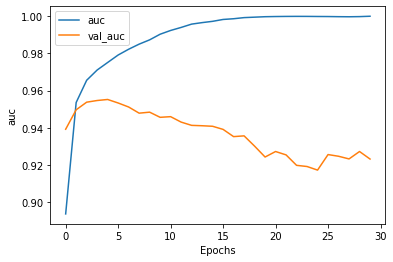

In [154]:
plot_graphs(clf_history, "auc")

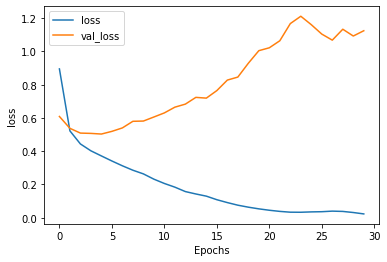

In [155]:
plot_graphs(clf_history, "loss")

Fijándonos en los gráficos parece que se ha producido sobreentrenamiento en el modelo. Los datos utilizados para entrenar el modelo se ajustan rápidamente como se puede comprobar en el gráfico de la medida AUC, donde tenemos valores muy cercanos a 1 a partir de 10 pasadas. En cambio, los datos utilizados para la evaluación parecen estancarse. Algo similar ocurre con la gráfica con la medida loss. El resultado para los datos de entrenamiento va mejorando mucho hasta los 20 epochs que se estabiliza, pero los datos de validación no siguen esta tendencia, más bien lo contrario.

**¿Qué pasaría si el modelo de clasificación lo entrenáramos con más datos?
¿Y si no utilizamos los embeddings de Glove? ¿Qué nos aportan ambas cosas?
¿Si utilizamos más datos es necesario utilizar los embeddings?**

En un primer razonamiento pensamos que si entrenamos el modelo con más datos obtendremos un mejor resultado a costa de aumentar el tiempo de ejecución. En cuanto a no utilizar los embeddings de Glove es posible que obtengamos peores resultados, ya que estos embeddings tienen unos pesos preentrenados para una serie de palabras en inglés que nos ayudan a realizar las predicciones en el modelo.

### Más datos

Cogemos 50.000 datos.

In [133]:
train_sample, data, data_labels = get_data_and_labels('class/train.csv', 50000)

50000
50000


Codificamos las etiquetas.

In [134]:
onehot_encoded = get_one_hot_encoding(data_labels)

[4 4 3 ... 1 1 4]
[3 3 2 ... 0 0 3]
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


Preprocesamos.

In [135]:
data_clean = clean_text(data)

Tokenizamos.

In [136]:
news_tokenizer = tokenization(data_clean)

Embeddings y vocabulario.

In [137]:
embedding_matrix = get_embedding_matrix(embeddings_index, news_tokenizer)

In [138]:
news_vocab_size = len(news_tokenizer.word_index) + 1
news_vocab_size

27870

Dividimos los datos de entrenamiento y test.

In [139]:
trainX, testX, trainY, testY = train_test_split(data_clean, onehot_encoded, test_size=0.2, random_state=123)

In [140]:
max_length = max_words(data_clean)

Codificamos los datos de entrada.

In [141]:
trainX_encoded = encode_sequences(news_tokenizer, max_length, trainX)

In [142]:
testX_encoded = encode_sequences(news_tokenizer, max_length, testX)

Definimos el modelo.

In [143]:
clf_model_more_data = define_model_clf(news_vocab_size, 300, max_length, 4, True, embedding_matrix)

In [144]:
adam = optimizers.Adam(lr=0.001)
clf_model_more_data.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['AUC'])

Entrenamos y guardamos.

In [145]:
history_more_data, clf_model_more_data = train_model(trainX_encoded, trainY, 30, 'clf_model_more_data', clf_model_more_data)

Epoch 1/30
63/63 [==============================] - 35s 519ms/step - loss: 0.5689 - auc: 0.9463 - val_loss: 0.4549 - val_auc: 0.9634

Epoch 00001: val_loss improved from inf to 0.45487, saving model to clf_model_more_data


INFO:tensorflow:Assets written to: clf_model_more_data\assets


INFO:tensorflow:Assets written to: clf_model_more_data\assets


Epoch 2/30
63/63 [==============================] - 27s 426ms/step - loss: 0.4191 - auc: 0.9685 - val_loss: 0.4306 - val_auc: 0.9671

Epoch 00002: val_loss improved from 0.45487 to 0.43059, saving model to clf_model_more_data


INFO:tensorflow:Assets written to: clf_model_more_data\assets


INFO:tensorflow:Assets written to: clf_model_more_data\assets


Epoch 3/30
63/63 [==============================] - 30s 472ms/step - loss: 0.3846 - auc: 0.9733 - val_loss: 0.4210 - val_auc: 0.9682

Epoch 00003: val_loss improved from 0.43059 to 0.42099, saving model to clf_model_more_data


INFO:tensorflow:Assets written to: clf_model_more_data\assets


INFO:tensorflow:Assets written to: clf_model_more_data\assets


Epoch 4/30
63/63 [==============================] - 28s 450ms/step - loss: 0.3574 - auc: 0.9767 - val_loss: 0.4156 - val_auc: 0.9695

Epoch 00004: val_loss improved from 0.42099 to 0.41562, saving model to clf_model_more_data


INFO:tensorflow:Assets written to: clf_model_more_data\assets


INFO:tensorflow:Assets written to: clf_model_more_data\assets


Epoch 5/30
63/63 [==============================] - 30s 472ms/step - loss: 0.3250 - auc: 0.9807 - val_loss: 0.4103 - val_auc: 0.9703

Epoch 00005: val_loss improved from 0.41562 to 0.41027, saving model to clf_model_more_data


INFO:tensorflow:Assets written to: clf_model_more_data\assets


INFO:tensorflow:Assets written to: clf_model_more_data\assets


Epoch 6/30
63/63 [==============================] - 29s 468ms/step - loss: 0.2971 - auc: 0.9837 - val_loss: 0.4166 - val_auc: 0.9700

Epoch 00006: val_loss did not improve from 0.41027
Epoch 7/30
63/63 [==============================] - 29s 455ms/step - loss: 0.2642 - auc: 0.9870 - val_loss: 0.4259 - val_auc: 0.9688

Epoch 00007: val_loss did not improve from 0.41027
Epoch 8/30
63/63 [==============================] - 28s 452ms/step - loss: 0.2299 - auc: 0.9901 - val_loss: 0.4401 - val_auc: 0.9684

Epoch 00008: val_loss did not improve from 0.41027
Epoch 9/30
63/63 [==============================] - 29s 455ms/step - loss: 0.2010 - auc: 0.9922 - val_loss: 0.4562 - val_auc: 0.9664

Epoch 00009: val_loss did not improve from 0.41027
Epoch 10/30
63/63 [==============================] - 29s 454ms/step - loss: 0.1672 - auc: 0.9947 - val_loss: 0.4922 - val_auc: 0.9648

Epoch 00010: val_loss did not improve from 0.41027
Epoch 11/30
63/63 [==============================] - 29s 461ms/step - loss

Cargamos el modelo.

In [146]:
model_clf_more_data = load_model('clf_model_more_data')

Hagamos las predicciones.

In [147]:
preds = model_clf_more_data.predict_classes(testX_encoded.reshape((testX_encoded.shape[0],testX_encoded.shape[1])))

[2 2 3 ... 1 1 3]


In [148]:
testY_decoded = np.argmax(testY, axis=1)

Evaluamos.

In [150]:
print_cofusion_matrix(testY_decoded, preds, [0,1,2,3])

      0     1     2     3
0  2184   118   130    92
1    79  2228    67    56
2   119    89  2055   260
3   102    74   263  2084


In [151]:
print(metrics.classification_report(testY_decoded, preds, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2524
           1       0.89      0.92      0.90      2430
           2       0.82      0.81      0.82      2523
           3       0.84      0.83      0.83      2523

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.85      0.86      0.85     10000



Viendo las distintas medidas, podemos observar una mejora respecto al modelo con 10.000 datos. Este hecho confirma lo que habíamos supuesto al inicio del ejercicio. Utilizar más datos para la construcción del modelo ayuda a tener mejores resultados pero a cambio de incrementar el coste computacional.

Este problema es asumible, pero dependiendo de la situación, utilizar más datos puede ser la mejor solución o no.

### Sin embeddings de Glove

Cogemos los datos.

In [167]:
train_sample, data, data_labels = get_data_and_labels('class/train.csv', 10000)

10000
10000


Codificamos las etiquetas.

In [168]:
onehot_encoded = get_one_hot_encoding(data_labels)

[3 1 3 ... 3 3 4]
[2 0 2 ... 2 2 3]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Limpiamos los títulos.

In [169]:
data_clean = clean_text(data)

Tokenizamos y obtenemos el tamaño del vocabulario.

In [170]:
news_tokenizer = tokenization(data_clean)

In [171]:
news_vocab_size = len(news_tokenizer.word_index) + 1
news_vocab_size

12710

Separamos los datos de entrenamiento y test.

In [172]:
trainX, testX, trainY, testY = train_test_split(data_clean, onehot_encoded, test_size=0.2, random_state=123)

In [173]:
max_length = max_words(data_clean)

Codificamos los datos de entrada.

In [174]:
trainX_encoded = encode_sequences(news_tokenizer, max_length, trainX)

In [175]:
testX_encoded = encode_sequences(news_tokenizer, max_length, testX)

Definimos el modelo sin los embeddings de Glove.

In [176]:
clf_model_no_glove = define_model_clf(news_vocab_size, 300, max_length, 4)

In [177]:
adam = optimizers.Adam(lr=0.001)
clf_model_no_glove.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['AUC'])

Entrenamos el modelo.

In [178]:
history_no_glove, clf_model_no_glove = train_model(trainX_encoded, trainY, 30, 'clf_model_no_glove', clf_model_no_glove)

Epoch 1/30
13/13 [==============================] - 11s 608ms/step - loss: 1.3545 - auc: 0.6733 - val_loss: 1.2362 - val_auc: 0.8503

Epoch 00001: val_loss improved from inf to 1.23620, saving model to clf_model_no_glove


INFO:tensorflow:Assets written to: clf_model_no_glove\assets


INFO:tensorflow:Assets written to: clf_model_no_glove\assets


Epoch 2/30
13/13 [==============================] - 11s 826ms/step - loss: 0.8723 - auc: 0.9342 - val_loss: 0.7872 - val_auc: 0.9080

Epoch 00002: val_loss improved from 1.23620 to 0.78715, saving model to clf_model_no_glove


INFO:tensorflow:Assets written to: clf_model_no_glove\assets


INFO:tensorflow:Assets written to: clf_model_no_glove\assets


Epoch 3/30
13/13 [==============================] - 9s 667ms/step - loss: 0.3674 - auc: 0.9766 - val_loss: 0.7889 - val_auc: 0.9137

Epoch 00003: val_loss did not improve from 0.78715
Epoch 4/30
13/13 [==============================] - 8s 625ms/step - loss: 0.1685 - auc: 0.9952 - val_loss: 0.8253 - val_auc: 0.9138

Epoch 00004: val_loss did not improve from 0.78715
Epoch 5/30
13/13 [==============================] - 8s 624ms/step - loss: 0.0863 - auc: 0.9989 - val_loss: 0.9343 - val_auc: 0.9090

Epoch 00005: val_loss did not improve from 0.78715
Epoch 6/30
13/13 [==============================] - 8s 618ms/step - loss: 0.0490 - auc: 0.9995 - val_loss: 1.1064 - val_auc: 0.9004

Epoch 00006: val_loss did not improve from 0.78715
Epoch 7/30
13/13 [==============================] - 8s 646ms/step - loss: 0.0343 - auc: 0.9997 - val_loss: 1.2366 - val_auc: 0.8929

Epoch 00007: val_loss did not improve from 0.78715
Epoch 8/30
13/13 [==============================] - 9s 660ms/step - loss: 0.0222

Cargamos el modelo.

In [179]:
model_clf_no_glove = load_model('clf_model_no_glove')

Hacemos las predicciones y evaluamos.

In [180]:
preds = model_clf_no_glove.predict_classes(testX_encoded.reshape((testX_encoded.shape[0],testX_encoded.shape[1])))

In [181]:
testY_decoded = np.argmax(testY, axis=1)

In [182]:
print_cofusion_matrix(testY_decoded, preds, [0,1,2,3])

     0    1    2    3
0  381   41   46   23
1   37  394   47   23
2   37   41  371   54
3   40   45   81  339


In [183]:
print(metrics.classification_report(testY_decoded, preds, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       491
           1       0.76      0.79      0.77       501
           2       0.68      0.74      0.71       503
           3       0.77      0.67      0.72       505

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



Aquí también se cumple lo que habíamos supuesto. Tenemos peores resultados, aunque dependiendo de los requisitos podrían ser aceptables.

El uso de embeddings preentrantes, como ya hemos visto en el punto 1, nos ayuda mucho en problemas relacionados con el procesamiento de lenguaje natural. Una de las principales ventajas es que no es necesario tener grandes volúmenes de datos que entrenar durante horas, ya que podemos partir de unos pesos ya trabajados.